## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [2]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_max_intensity_for_dataset, load_and_prepare_images_from_txt
from utils.model_utils import train_and_eval
from torch import nn
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
EPOCHS = 50
# image_path = "D:/AIF_DCE"
image_path = "D:/iCAT_IMAGES/"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


c:\Users\svenalrik\anaconda3\envs\dev-env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
# Patient 102(1) contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)
# Patient 112(11) lacks a single pixel array
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]


In [4]:
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars=[
                     'Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])


In [5]:
vol_intensities = get_max_intensity_for_dataset(image_data)
train_images, val_images, test_images, train_labels, val_labels, test_labels = load_and_prepare_images_from_txt(
    image_data, mca_labels, vol_intensities, SEED=SEED, extra_vols=5)


Added data 1090. Original amount of data 3264
Size training, val, and test data: 3437, 446, 471.
True labels in training: 1014 of 3437 (29.5%).
True labels in validation: 132 of 446 (29.6%).
True labels in test: 162 of 471 (34.4%).


In [6]:
from utils.datahandling_utils import SliceIntensityDataset
from torch.utils.data import DataLoader

train_dataset = SliceIntensityDataset(
    train_images, train_labels, normalize=True, crop=0.7)
val_dataset = SliceIntensityDataset(
    val_images, val_labels, normalize=True, crop=0.7)
test_dataset = SliceIntensityDataset(
    test_images, test_labels, normalize=True, crop=0.7)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
from models.dense_net_torch import DenseNet
torch.manual_seed(SEED)
model = DenseNet(growth_rate=15, num_init_features=28,
                 bn_size=3, drop_rate=0.1, num_classes=1)
print(
    f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)


Total number of trainable parameters 1203409


In [8]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('Model_crop_128_50.pt'))
model = model.to(device)
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 28, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(28, 45, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(45, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [9]:
# losses = train_and_eval(model, train_loader, val_loader, optimizer, criterion, EPOCHS, device, apr=True)


In [10]:
# Saving the model:
# torch.save(model.state_dict(), f"Model_crop_128_{EPOCHS}.pt")


In [11]:
# from utils.model_utils import get_model_performance_metrics
# train_sorted = get_model_performance_metrics(model, train_images, train_labels, device, True, 0.7)
# val_sorted = get_model_performance_metrics(model, val_images, val_labels, device, True, 0.7)


In [12]:
# print("Performance on training data:")
# print(f"TP: {len(train_sorted[0])} FP: {len(train_sorted[1])} TN: {len(train_sorted[2])} FN: {len(train_sorted[3])}\n")
# print("Performance on validation data:")
# print(f"TP: {len(val_sorted[0])} FP: {len(val_sorted[1])} TN: {len(val_sorted[2])} FN: {len(val_sorted[3])}\n")


In [13]:
import matplotlib.pyplot as plt
# Fonts similar to latex document
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.style.use('ggplot')


In [14]:
# import matplotlib.pyplot as plt
# # Fonts similar to latex document
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[0][:,0], label='Training loss')
# plt.plot(losses[0][:,1], label='Validation loss')
# plt.xlabel('Epoch')
# plt.minorticks_on()
# plt.ylabel('Loss')
# plt.title('Model loss')
# plt.legend(loc='upper right')


In [15]:
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[1][:,0], label='Validation accuracy')
# plt.plot(losses[1][:,1], label='Validation precision')
# plt.plot(losses[1][:,2], label='Validation recall')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.minorticks_on()
# plt.title('Accuracy, Precision, Recall')
# plt.legend(loc='lower right')


In [16]:
from utils.visualization_utils import display_predictions
# display_predictions(train_sorted, model, device, True, True, 0.7)
# display_predictions(val_sorted, model, device, True, True, 0.7)


In [17]:
def NLC_s2r(S, TR, FA):
    FA = FA*(np.pi/180)  # degree -> rad
    TR = TR / 1000  # ms -> s
    T_10 = 1.4
    S_0 = np.mean(S[:5])
    E_10 = np.exp(-TR/T_10)
    B = (1-E_10)/(1-E_10*np.cos(FA))
    A = np.nan_to_num(B*S/S_0)
    R1 = np.nan_to_num(-1/TR * np.log((1-A)/(1-A*np.cos(FA))))
    return R1 - np.mean(R1[:5])


def new_NLC_s2r(S, TR, FA):
    """
    Based off https://doi.org/10.1016/j.mri.2018.05.007

    R1(t) = -1/TR * (ln(B) - ln(C))
    B = A - S/S_0
    C = A - S/S_0 * cos(FA)
    A = (1-cos(FA)*e^(-TR))/(1-e^(-TR))
    """
    FA = FA*(np.pi/180)  # degree -> rad
    TR = TR / 1000  # ms -> s
    S_0 = np.mean(S[:5])
    S = S - S_0
    A = (1-np.cos(FA)*np.exp(-TR))/(1-np.exp(-TR))
    B = np.nan_to_num(A - S/S_0)
    C = np.nan_to_num(A - S/S_0 * np.cos(FA))
    R1 = -1/TR * (np.nan_to_num(np.log(B)) - np.nan_to_num(np.log(C)))
    return R1


def lc_s2r(S, TR=0, FA=0):
    r1 = 4.5
    T_10 = 1.4
    S_0 = np.mean(S[:5])
    return 1/(r1*T_10) * ((S/S_0)-1)


In [32]:
from operator import itemgetter
from typing import Callable
from utils.datahandling_utils import crop_image
from utils.model_utils import get_label_curves, visualize_curves
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from models.mouridsen import get_AIF_KMeans


def extract_AIF_mouridsen(images: dict, SEED: int, info: dict, visualize: bool = False) -> dict:
    curves = {}
    for slice_idx in images.keys():
        image = images[slice_idx]
        curves_coords = get_AIF_KMeans(
            image, SEED, min_voxels=20, visualize=visualize)
        curves[slice_idx] = curves_coords
    return curves


def get_MCA_prediction(model, data: pd.DataFrame, intensities: np.array, device: str, crop: float, one_pred: str = "single"):
    model.eval()
    patient = np.unique(data['Patient'])[0]
    volume = int(np.squeeze(
        intensities[np.where(intensities[:, 0] == patient)[0]])[1])
    slices = data.loc[(data['Patient'] == patient) &
                      (data['Volume'] == volume)].copy()
    slice_preds = []
    info = {}
    for i, (_, slice) in enumerate(slices.iterrows()):
        slice_num = slice['Slice']
        image = pdc.dcmread(slice['ImagePath'])
        if i == 3:
            info['FA'] = image.FlipAngle
            info['TR'] = image.RepetitionTime
        image = crop_image(image.pixel_array, crop)
        image = image/np.max(image)
        image = np.expand_dims(image, axis=(0, 1))
        image = torch.tensor(image, dtype=torch.float).to(device)
        pred = torch.sigmoid(model(image)).item()
        if int(round(pred)) == 1:
            slice_preds.append((slice_num, pred))
    if len(slice_preds) > 1:
        if one_pred == "single":
            slice_preds = sorted(slice_preds, key=itemgetter(0), reverse=True)
            idx = len(slice_preds) // 2
            return [slice_preds[idx][0]], info
        if one_pred == "sigmoid":
            slice_preds = sorted(slice_preds, key=itemgetter(1), reverse=True)
            return [slice_preds[0][0]], info
    return [i[0] for i in slice_preds], info


def filter_slices_on_mca_prediction(data, patient_num: int, mca_slices: list) -> dict:
    images = {}
    for slice_idx in mca_slices:
        slice_paths = data[(data['Patient'] == patient_num)
                           & (data['Slice'] == slice_idx)]
        slice_paths = slice_paths.sort_values(
            ['Patient', 'Volume', 'Slice'], ignore_index=True)
        image = []
        for path in slice_paths['ImagePath']:
            image.append(pdc.read_file(path).pixel_array)
        images[slice_idx] = np.array(image)
    return images


def single_eval_curve(model, image_data: pd.DataFrame, patient: int, vol_intensities: np.ndarray, device: str, seed: int, crop: float, visualize: bool, one_pred: str):
    images = image_data[image_data['Patient'] == patient]
    MCA_slices, slice_info = get_MCA_prediction(
        model, images, vol_intensities, device, crop, one_pred)
    filtered_slices = filter_slices_on_mca_prediction(
        images, patient, MCA_slices)
    if one_pred == "global":
        pred_curves = {}
        all_slices = np.stack(list(filtered_slices.values()))
        _pred_curves = get_AIF_KMeans(
            all_slices, seed, min_voxels=20, visualize=visualize)
        for s in filtered_slices.keys():
            pred_curves[s] = _pred_curves
    else:
        pred_curves = extract_AIF_mouridsen(
            filtered_slices, seed, slice_info, visualize)
    return pred_curves, slice_info


def eval_curves(model, image_data: pd.DataFrame, vol_intensities: np.ndarray, device: str, seed: int, crop: float, visualize: bool, signal_to_relaxation: Callable = None, one_pred: str = "single"):
    if one_pred not in ["single", "all", "global", "sigmoid"]:
        raise Exception(
            f"Arg: one_pred must be one of \"single\", \"all\", \"global\", \"sigmoid\". Given argument: \"{one_pred}\"")
    actual_curves = get_label_curves(image_data)
    results = []
    extractions = {}
    labels = {}
    for p in actual_curves.keys():
        print(f"Patient {p}")
        pred_curves, slice_info = single_eval_curve(
            model, image_data, p, vol_intensities, device, seed, crop, visualize, one_pred)
        for s in pred_curves.keys():
            if actual_curves[p] is None:
                results.append([p, s, None, None, None])
                continue

            if visualize and one_pred != "global":
                volume = int(np.squeeze(
                    vol_intensities[np.where(vol_intensities[:, 0] == p)[0]])[1])
                slice = image_data[((image_data['Patient'] == p) & (
                    image_data["Slice"] == s)) & (image_data['Volume'] == volume)]
                image = pdc.dcmread(slice['ImagePath'].item()).pixel_array
                visualize_curves(pred_curves[s][0], pred_curves[s][1], image,
                                 slice_info['TR'], slice_info['FA'], signal_to_relaxation)

            pred = np.mean(pred_curves[s][0], axis=0)
            if signal_to_relaxation is not None:
                pred = signal_to_relaxation(
                    pred, slice_info['TR'], slice_info['FA'])
            extractions[(p, s)] = pred
            labels[(p, s)] = actual_curves[p]

            results.append([p, s, mae(actual_curves[p], pred), mse(
                actual_curves[p], pred, squared=False), r2(actual_curves[p], pred)])
    return pd.DataFrame(results, columns=['Patient', 'Slice', 'MAE', 'RMSE', 'R2'], index=None), extractions, labels


In [34]:
from utils.model_utils import eval_curves
curve_evals, extractions, label_curves = eval_curves(
    model, image_data, vol_intensities, device, SEED, crop=0.7, visualize=False, signal_to_relaxation=NLC_s2r, one_pred="global")


Patient 2


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 3


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 4


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 5


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 6


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 7


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 8


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 9


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 10


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 12


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 13


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 14


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 15


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 16


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 17


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 18


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 19


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 20


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 21


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 22


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 23


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 24


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 25


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 26


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 27


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 28


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 29


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 30


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 31


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 32


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 33


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 34


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 35


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 36


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 37


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 38


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 39


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 40


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 41


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 42


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 43


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 44


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 45


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 46


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 47


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 48


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 49


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 50


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 51


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 52


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 53


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 54


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 55


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 56


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 57


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 58


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 59


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 60


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 61


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 62


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 63


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 64


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 65


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 66


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 67


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 68


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 69


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


Patient 70


d:\dev\Masterthesis\models\mouridsen.py:22: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


array([[<Axes: title={'center': 'MAE'}>, <Axes: title={'center': 'R2'}>],
       [<Axes: title={'center': 'RMSE'}>, <Axes: >]], dtype=object)

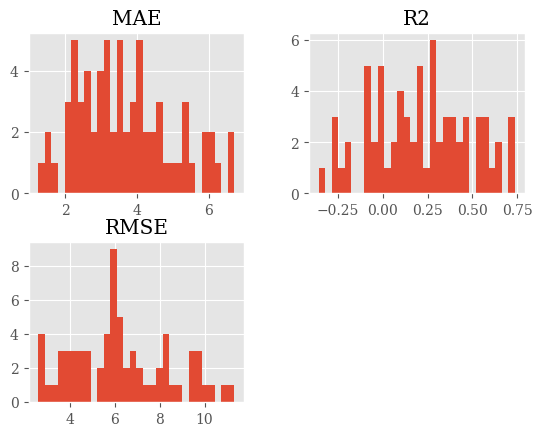

In [38]:
curve_evals.hist(['MAE', 'R2', 'RMSE'], bins=30)


Patient 64


C:\Users\svenalrik\AppData\Local\Temp\ipykernel_28620\2502002360.py:19: RuntimeWarning: invalid value encountered in divide
  standardized_curves = volume/areas_stacked
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_28620\2502002360.py:19: RuntimeWarning: invalid value encountered in divide
  standardized_curves = volume/areas_stacked
C:\Users\svenalrik\AppData\Local\Temp\ipykernel_28620\2502002360.py:19: RuntimeWarning: invalid value encountered in divide
  standardized_curves = volume/areas_stacked


122


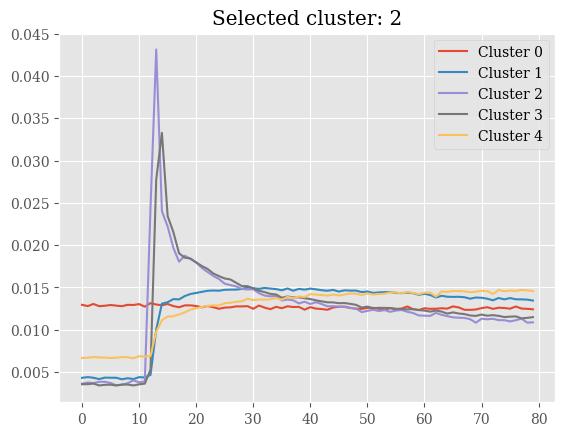

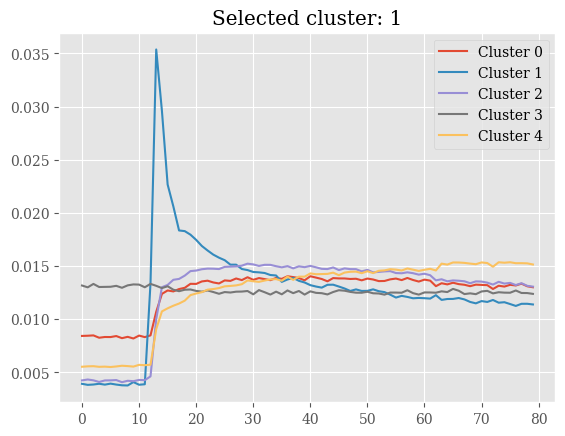

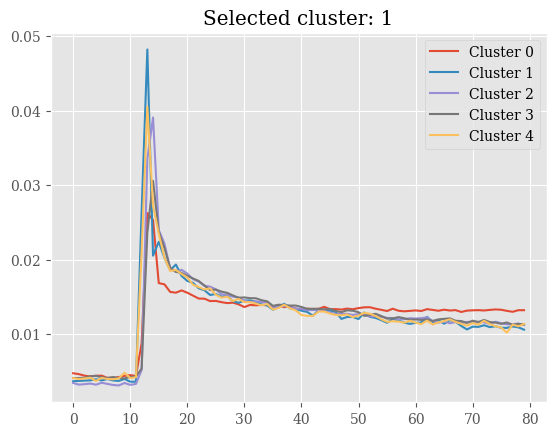

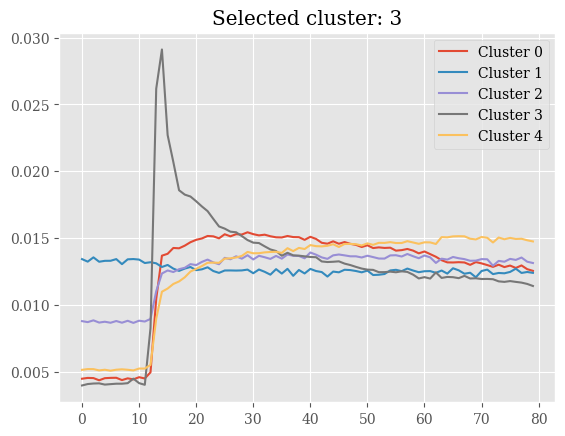

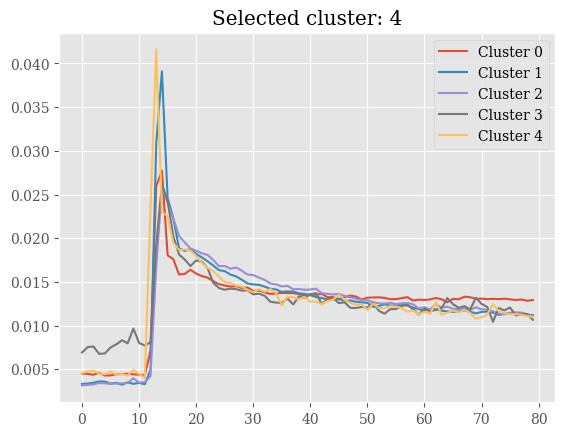

In [29]:
# single_data = image_data[image_data['Patient'] == 64]
# pred_curve, extractions, label_curves = eval_curves(
#     model, single_data, vol_intensities, device, SEED, crop=0.7, visualize=True, signal_to_relaxation=NLC_s2r, one_pred="global")


Text(0.5, 1.0, 'Predicted vs. actual AIF')

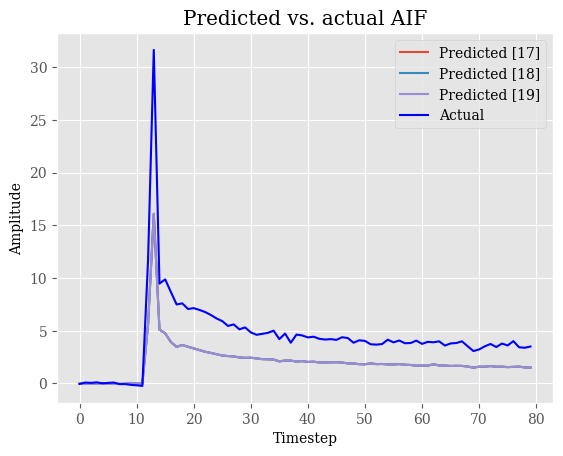

In [33]:
fig = plt.figure()
for p, s in extractions.keys():
    plt.plot(extractions[(p, s)], label=f"Predicted [{s}]")
    # plt.axvline(x = np.argmax(label_curves[(p,s)]), color = "blue", linestyle="dashed", linewidth = 0.4)
    # plt.axvline(x = np.argmax(extractions[(p,s)]), color = "red", linestyle="dashed", linewidth = 0.4)
plt.plot(label_curves[(p, s)], color="blue", label="Actual")
plt.legend(loc="upper right")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.title("Predicted vs. actual AIF")


In [23]:
def global_aif():
    pass


def sigmoid_aif():
    pass
